# Análise de Dados Bancários
**Autora: Paula Cecília Calixto**

Neste projeto, realizaremos uma análise de dados bancários com o objetivo de analisar os sentimentos nas narrativas dos clientes sobre diferentes produtos bancários, como cartões de crédito, serviços de varejo bancário e relatórios de crédito. Isso pode ajudar os bancos a entender melhor a percepção do cliente em relação a seus produtos e serviços.

## Coleta de Dados
Os dados foram obtidos através do Kaggle, disponível em [Bank Customer Complaint Analysis](https://www.kaggle.com/datasets/adhamelkomy/bank-customer-complaint-analysis). Eles consistem nos resultados das queixas dos clientes em relação aos produtos e serviços bancários.
rios.
rios.
rios.
rios.
es decorrentes dos resultados].



In [1]:
!pip install sentence-transformers
!pip install catboost

import os
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import  stopwords
import string
from colorama import Fore, Back, Style
import matplotlib.pyplot as plt
import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sentence_transformers import SentenceTransformer

# feature extractor
emmedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

SEED = 32

os.environ['HF_HUB_DISABLE_SYMLINKS_WARNING'] = '1'

Lendo dados

In [2]:
data = pd.read_csv('complaints.csv')
data = data.drop_duplicates(subset = ['narrative'], keep = 'first').reset_index(drop = True)
data.drop(['Unnamed: 0'], axis = 1, inplace = True)
data.head()

,product,narrative
0,credit_card,purchase order day shipping amount receive pro...
1,credit_card,forwarded message date tue subject please inve...
2,retail_banking,forwarded message cc sent friday pdt subject f...
3,credit_reporting,payment history missing credit report speciali...
4,credit_reporting,payment history missing credit report made mis...


## Pré-processamento de Dados

Nesta seção, realizamos o pré-processamento dos dados antes de alimentá-los ao modelo de anális:


In [3]:
# funções de pré-processamento
stop_words = set(stopwords.words('english'))

def text_preprocessing(text):
    text = str(text)
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\w*xx+\w*', '', text)
    return text


def drop_stopwords(text):
    dropped = [word for word in text.split() if word not in stop_words]
    final_text = ' '.join(dropped)
    return final_text


# Aplicar funções de pré-processamento
data_processed = data.copy()
data_processed['narrative'] = data_processed['narrative'].apply(text_preprocessing).apply(drop_stopwords)

# Codificação de etiquetas para a coluna 'product'
LE = LabelEncoder()
data_processed['encoded_product'] = LE.fit_transform(data_processed['product'])

# Remover coluna 'product' original
data_processed.drop(columns=['product'], inplace=True)

# uma função para calcular e traçar previsões
def plot_prediction_results(model, X_data, y_data, target_names = list(LE.classes_)):
    pred = model.predict(X_data)
    
    mse = mean_squared_error(y_data, pred)
    f1 = f1_score(y_data, pred, average = 'weighted')
    acc = accuracy_score(y_data, pred)
    cm = confusion_matrix(y_data, pred)
    
    clf = classification_report(y_data, pred, target_names = target_names)
    
    print('Mean Squared Error :\t{0:.5f}'.format(mse))
    print('Weighted F1 Score :\t{0:.3f}'.format(f1))
    print('Accuracy Score :\t{0:.3f} %'.format(acc*100))
    print('--'*35)
    
    print('\n Classification Report:\n',clf)
    print('--'*35)

    print('\n Confusion Matrix: \n')

    cmd = ConfusionMatrixDisplay(cm, display_labels = target_names)
    fig, axs = plt.subplots(figsize=(4,4))
    cmd.plot(ax=axs, cmap="bone", xticks_rotation="vertical", colorbar = False)

In [4]:
# dados após operações de pré-processamento
data_processed.head()

,narrative,encoded_product
0,purchase order day shipping amount receive pro...,0
1,forwarded message date tue subject please inve...,0
2,forwarded message cc sent friday pdt subject f...,4
3,payment history missing credit report speciali...,1
4,payment history missing credit report made mis...,1


## Divisão de Dados de Treinamento e Teste

Nesta seção, os dados são divididos em conjuntos de treinamento e teste usando a função `train_test_split` da biblioteca `sklearn`. O conjunto de dados processado (`data_processed`) é dividido em `type_train_data` e `type_test_data`, com uma proporção de 80% para treinamento e 20% para teste.


In [5]:
# divisão de treinamento e teste
type_train_data, type_test_data = train_test_split(data_processed, test_size = 0.2, random_state = SEED, shuffle = False)

type_train_data = type_train_data.reset_index(drop = True)
type_test_data = type_test_data.reset_index(drop = True)

print('train sample size\t', type_train_data.shape[0])
print('test sample size\t', type_test_data.shape[0])

train sample size	 99578
test sample size	 24895


## Criação de Recursos de Texto e Redução de Dimensionalidade
Nesta seção, os recursos de texto são criados usando um modelo de incorporação (embedding_model). Os dados de texto são codificados usando o método encode do modelo de incorporação, resultando em representações vetoriais densas para cada texto. Em seguida, a dimensionalidade desses recursos é reduzida usando Análise de Componentes Principais (PCA) para melhorar a eficiência computacional e reduzir a redundância nos dados.

In [6]:
# criação de recursos de texto (384 recursos)
train_embeddings = emmedding_model.encode(list(type_train_data['narrative'].values), show_progress_bar = True)
test_embeddings = emmedding_model.encode(list(type_test_data['narrative'].values), show_progress_bar = True)
    

# redução de dimensionalidade
pca = PCA(300)

# últimos recursos de texto
train_pca = pca.fit_transform(train_embeddings)
test_pca = pca.transform(test_embeddings)

print('\nbefore PCA, train feature size\t', train_embeddings.shape[1])
print('\nafter PCA, train feature size\t', train_pca.shape[1])

Batches:   0%|          | 0/3112 [00:00<?, ?it/s]

Batches:   0%|          | 0/778 [00:00<?, ?it/s]


before PCA, train feature size	 384

after PCA, train feature size	 300


## Treinamento e Avaliação do Modelo

Nesta seção, treinamos um modelo de classificação e avaliamos seu desempenho nos dados de teste.

In [7]:
X_train_pca = train_pca
y_train = type_train_data['encoded_product']

X_test_pca = test_pca
y_test = type_test_data['encoded_product']

In [8]:
# modelo sintonizado
cat_model = CatBoostClassifier(verbose = 500)
cat_model.fit(X_train_pca, y_train)

Learning rate set to 0.100053
0:	learn: 1.4463707	total: 978ms	remaining: 16m 17s
500:	learn: 0.4161538	total: 4m 12s	remaining: 4m 11s
999:	learn: 0.3424983	total: 8m 1s	remaining: 0us


Mean Squared Error :	0.56168
Weighted F1 Score :	0.830
Accuracy Score :	83.129 %
----------------------------------------------------------------------

 Classification Report:
                      precision    recall  f1-score   support

        credit_card       0.73      0.74      0.74      2006
   credit_reporting       0.88      0.89      0.88     13410
    debt_collection       0.75      0.70      0.72      4394
mortgages_and_loans       0.81      0.82      0.81      3186
     retail_banking       0.81      0.84      0.82      1899

           accuracy                           0.83     24895
          macro avg       0.80      0.80      0.80     24895
       weighted avg       0.83      0.83      0.83     24895

----------------------------------------------------------------------

 Confusion Matrix: 



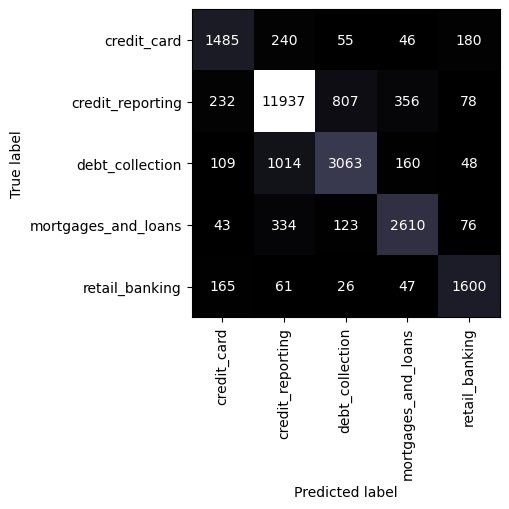

In [9]:
plot_prediction_results(cat_model, X_test_pca, y_test)

Os resultados indicam que o modelo possui um desempenho geral bastante sólido, com uma precisão média de 83.129% e um F1 Score ponderado de 0.830. 

## Regressão Logística
**classificação dos dados.**

Medir o tempo de execução da célula,criar um pipeline e treinar o modelo de Regressão Logística utilizando os dados de treinamento. 

In [10]:
%%time
log_reg = make_pipeline(TfidfVectorizer(), LogisticRegression(C=2.0, max_iter = 500))
log_reg.fit(type_train_data['narrative'].values, y_train)

CPU times: total: 23.4 s
Wall time: 55.1 s


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression',
                 LogisticRegression(C=2.0, max_iter=500))])

## Plotando os resultados da previsão do modelo.

Este método irá imprimir várias métricas de avaliação, como o erro quadrático médio, o score F1 ponderado, a precisão e a matriz de confusão.

Mean Squared Error :	0.49504
Weighted F1 Score :	0.850
Accuracy Score :	85.021 %
----------------------------------------------------------------------

 Classification Report:
                      precision    recall  f1-score   support

        credit_card       0.75      0.77      0.76      2006
   credit_reporting       0.89      0.90      0.90     13410
    debt_collection       0.79      0.73      0.76      4394
mortgages_and_loans       0.82      0.84      0.83      3186
     retail_banking       0.83      0.87      0.85      1899

           accuracy                           0.85     24895
          macro avg       0.82      0.82      0.82     24895
       weighted avg       0.85      0.85      0.85     24895

----------------------------------------------------------------------

 Confusion Matrix: 



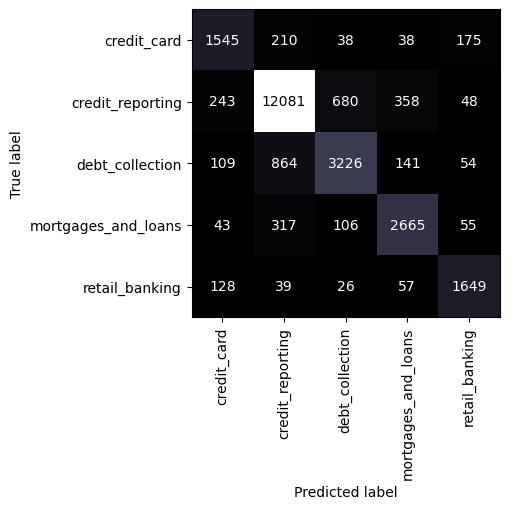

In [11]:
plot_prediction_results(log_reg, type_test_data['narrative'].values, y_test)

O modelo de Regressão Logística obteve um desempenho satisfatório.

## Probabilidades de Previsão
Calculando as probabilidades previstas para cada classe de destinoo 

In [12]:
# probabilidades de previsão
pred_proba1 = cat_model.predict_proba(X_test_pca)
pred_proba2 = log_reg.predict_proba(type_test_data['narrative'].values)

## Previsões Finais do Conjunto e Avaliação do Desempenho
Combinando as previsões de dois modelos com base em suas probabilidades previstas, utilizando uma ponderação para cada modelo. Para melhorar o desempenho preditivo ao aproveitar as forças de diferentes algoritmos de aprendizado de máquina.

In [13]:
# previsões finais do conjunto
# 32% Classificador CatBoost + 68% Regressão Logística

final_test_pred_ = (pred_proba1*0.32 + pred_proba2*0.68)
final_test_pred = np.argmax(final_test_pred_, axis = 1)

Mean Squared Error :	0.46708
Weighted F1 Score :	0.857
Accuracy Score :	85.764 %
----------------------------------------------------------------------

 Classification Report:
                      precision    recall  f1-score   support

        credit_card       0.77      0.78      0.78      2006
   credit_reporting       0.90      0.91      0.90     13410
    debt_collection       0.80      0.74      0.77      4394
mortgages_and_loans       0.83      0.84      0.84      3186
     retail_banking       0.84      0.88      0.86      1899

           accuracy                           0.86     24895
          macro avg       0.83      0.83      0.83     24895
       weighted avg       0.86      0.86      0.86     24895

----------------------------------------------------------------------


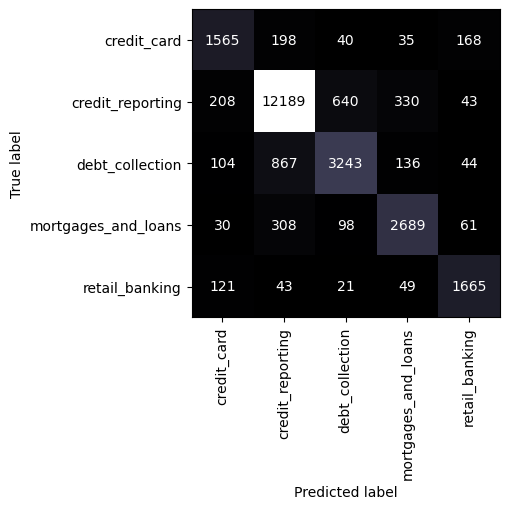

In [14]:
mse = mean_squared_error(y_test, final_test_pred)
f1 = f1_score(y_test, final_test_pred, average = 'weighted')
acc = accuracy_score(y_test, final_test_pred)
cm = confusion_matrix(y_test, final_test_pred)

clf = classification_report(y_test, final_test_pred, target_names = list(LE.classes_))

print('Mean Squared Error :\t{0:.5f}'.format(mse))
print('Weighted F1 Score :\t{0:.3f}'.format(f1))
print('Accuracy Score :\t{0:.3f} %'.format(acc*100))
print('--'*35)
    
print('\n Classification Report:\n',clf)
print('--'*35)


# matriz de confusão
cmd = ConfusionMatrixDisplay(cm, display_labels = list(LE.classes_))
fig, axs = plt.subplots(figsize=(4,4))
cmd.plot(ax=axs, cmap="bone", xticks_rotation="vertical", colorbar = False)

Os resultados mostram que o modelo tem um desempenho bastante satisfatório na classificação das classes de destino, com boa precisão, revocação e acurácia.